### Created by: Anthony D. Cho
### Last update: 07.12.2021

**Subject**: Classification (Transformer - keras, tensorflow) - Reviews of Amazon Baby Products

## Libraries dependencies

In [1]:
from time import time
import matplotlib.pyplot as plt
from numpy import round
from pandas import read_csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Text processing functions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Model functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

## Customized functions

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

In [3]:
## Customized embedding layer

class TokenAndPositionEmbedding(layers.Layer):
    """
        Two seperate embedding layers, one for tokens, one for token index (positions).
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        """
            INPUT:
                @param maxlen: sequence length
                @type maxlen: int
                
                @param vocab_size: maximum number of words to keep (for tokens)
                @type vocab_size: int

                @param embed_dim: dimension of the dense embedding
                @type embed_dim: int
        """
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_embedding = layers.Embedding(input_dim=vocab_size, 
                                                output_dim=embed_dim)
        self.position_embedding = layers.Embedding(input_dim=maxlen, 
                                                   output_dim=embed_dim)

    def call(self, x):
        """
            INPUT:
                @param x: token sequence
                @type x: numpy.ndarray

            OUTPUT:
                @param results: sum of embeddings
                @type results: tensorflow.tensor
        """

        ## Compute sequence length
        maxlen = tf.shape(x)[-1]

        ## Compute embedding to positions
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.position_embedding(positions)

        ## Compute embedding to sequence
        x = self.token_embedding(x)

        ## Sum of embedding results
        results = x + positions 

        ## return results
        return results


In [4]:
## Transformer Layer definition

class TransformerLayer(layers.Layer):
    """
        Transformer layer implementation
    """
    
    def __init__(self, num_heads, embed_dim, ff_dim, rate=0.1):
        """
            INPUT:
                @param num_heads: Number of attention heads (Attention layer).
                @type num_heads: int
                
                @param embed_dim: Size of each attention head for query and key (Attention layer).
                @type embed_dim: int
                
                @param ff_dim: 
                @type ff_dim: int
                
                @param rate: 
                @type rate: float
        """
        super(TransformerLayer, self).__init__()
        
        ## Multi-head attention layer
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, 
                                                   key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        """
            INPUT:
                @param inputs
                @type inputs
                
                @param training: training mode
                @type training: bool
            
            OUTPUT:
                @param output: result of transformer layer
                @type output: tensorflow.tensor
            
        """

        ## Compute attention
        attn_output = self.attention(inputs, inputs)

        ## Compute dropout and normalization
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ## Dense layer conection and dropout
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        ## Compute normalization
        output = self.layernorm2(out1 + ffn_output)

        ## return output
        return output

# Problem: Reviews of Amazon Baby Products

**Target**: Sentiment (0: Negative, 1: Positive)

## Data loading
Source: [Reviews of Amazon Baby Products](https://www.kaggle.com/sameersmahajan/reviews-of-amazon-baby-products) (Kaggle)

In [5]:
## Downloading data
!wget https://github.com/adoc-box/Datasets/blob/6d80f44a12aca282b7f2ff638866edef4806a282/amazon_baby.zip?raw=True

## Rename file
!mv "amazon_baby.zip?raw=True" "amazon_baby.zip"

## Un-compress downloaded zip file
!unzip amazon_baby.zip

--2021-12-08 01:05:31--  https://github.com/adoc-box/Datasets/blob/6d80f44a12aca282b7f2ff638866edef4806a282/amazon_baby.zip?raw=True
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/adoc-box/Datasets/raw/6d80f44a12aca282b7f2ff638866edef4806a282/amazon_baby.zip [following]
--2021-12-08 01:05:31--  https://github.com/adoc-box/Datasets/raw/6d80f44a12aca282b7f2ff638866edef4806a282/amazon_baby.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adoc-box/Datasets/6d80f44a12aca282b7f2ff638866edef4806a282/amazon_baby.zip [following]
--2021-12-08 01:05:31--  https://raw.githubusercontent.com/adoc-box/Datasets/6d80f44a12aca282b7f2ff638866edef4806a282/amazon_baby.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.

In [6]:
## Load data
data = read_csv('amazon_baby.csv')

## Lets assing sentiment as: Ratings {1,2} to 0, and the rest to 1
data['sentiment'] = data['rating'].apply(lambda x: 0 if x in [1, 2] else 1)

## Predictor and target
X, y = data['review'], data['sentiment']

## Display first 4 records
data.head(4)

,name,review,rating,sentiment
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,1
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,1


## Pre-processing

In [7]:
## Data partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20211206)

## Convert DataFrame to list
X_train = [str(p) for p in X_train]
X_test = [str(p) for p in X_test]

## Display shape
print('(train) X: {}, y: {}'.format(len(X_train), len(y_train)))
print('(test) X: {}, y: {}'.format(len(X_test), len(y_test)))

(train) X: 165177, y: 165177
(test) X: 18354, y: 18354


### Text transformation

In [8]:
## Number of attention heads
NUM_ATTENTION_HEADS = 4

## maximum number of words to keep
MAX_WORDS = 40000

## Embeeding dimension
EMBEDDING_DIM = 8

## Maximum length for each review
TEXT_MAX_LENG = 120

## Review truncating method (pre or post)
TRUNC_TYPE = 'post'

## out-of-vocabulary label
OOV_LABEL = '<OOV>'

## Padding method (pre or post text)
PAD_TYPE = 'post'

## Tokenizer instance
tokenizer = Tokenizer(num_words=MAX_WORDS, 
                      oov_token=OOV_LABEL)

## Update internal vocabulary based on a list of texts
tokenizer.fit_on_texts(X_train)

## Display word-index in tokenizer
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'i': 4,
 'it': 5,
 'to': 6,
 'a': 7,
 'is': 8,
 'this': 9,
 'for': 10,
 'my': 11,
 'of': 12,
 'in': 13,
 'that': 14,
 'with': 15,
 'on': 16,
 'was': 17,
 'but': 18,
 'have': 19,
 'we': 20,
 'so': 21,
 'not': 22,
 'you': 23,
 'are': 24,
 'as': 25,
 'one': 26,
 'baby': 27,
 'they': 28,
 'very': 29,
 'when': 30,
 'be': 31,
 'great': 32,
 'would': 33,
 'just': 34,
 'at': 35,
 'up': 36,
 'out': 37,
 'use': 38,
 'can': 39,
 'like': 40,
 "it's": 41,
 'all': 42,
 'these': 43,
 'our': 44,
 'if': 45,
 'had': 46,
 'he': 47,
 'them': 48,
 'she': 49,
 'or': 50,
 'her': 51,
 'has': 52,
 'love': 53,
 'seat': 54,
 'little': 55,
 'easy': 56,
 'get': 57,
 'old': 58,
 'from': 59,
 'well': 60,
 'only': 61,
 'will': 62,
 'because': 63,
 'more': 64,
 'really': 65,
 'also': 66,
 'product': 67,
 'time': 68,
 'about': 69,
 'other': 70,
 'too': 71,
 'bought': 72,
 'no': 73,
 'than': 74,
 'good': 75,
 'much': 76,
 'son': 77,
 'me': 78,
 'now': 79,
 "don't": 80,
 'there': 81,
 

In [9]:
## Transforms each text in train texts to a sequence of integers.
X_train_sequences = tokenizer.texts_to_sequences(X_train)

## Pads sequences to the same length.
X_train_sequences = pad_sequences(sequences=X_train_sequences, 
                                  maxlen=TEXT_MAX_LENG, 
                                  truncating=TRUNC_TYPE, 
                                  padding=PAD_TYPE)

## Transforms each text in test texts to a sequence of integers.
X_test_sequences = tokenizer.texts_to_sequences(X_test)

## Pads sequences to the same length.
X_test_sequences = pad_sequences(sequences=X_test_sequences, 
                                 maxlen=TEXT_MAX_LENG,
                                 truncating=TRUNC_TYPE,
                                 padding=PAD_TYPE)

## Display shape
print('(train) X: {}, y: {}'.format(X_train_sequences.shape, len(y_train)))
print('(test) X: {}, y: {}'.format(X_test_sequences.shape, len(y_test)))

(train) X: (165177, 120), y: 165177
(test) X: (18354, 120), y: 18354


## Model building

In [10]:
## Model building
inputs = layers.Input(shape=(TEXT_MAX_LENG,), 
                      name='Input')
embedding_layer = TokenAndPositionEmbedding(TEXT_MAX_LENG, 
                                            MAX_WORDS, 
                                            EMBEDDING_DIM)
x = embedding_layer(inputs)
transformer = TransformerLayer(NUM_ATTENTION_HEADS, 
                               EMBEDDING_DIM, 
                               ff_dim=32)
x = transformer(x)
x = layers.GlobalAveragePooling1D(name='GlobalAvgPool')(x)
x = layers.Dropout(rate=0.1, name='Dropout_01')(x)
x = layers.Dense(20, activation="relu", name='Dense')(x)
x = layers.Dropout(rate=0.1, name='Dropout_02')(x)
outputs = layers.Dense(1, activation="sigmoid", name='Output')(x)

## Model instance
model = Model(inputs=inputs, outputs=outputs, name='Transformer')

## display model
model.summary()

Model: "Transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 120)]             0         
                                                                 
 token_and_position_embeddin  (None, 120, 8)           320960    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_layer (Transfor  (None, 120, 8)           1712      
 merLayer)                                                       
                                                                 
 GlobalAvgPool (GlobalAverag  (None, 8)                0         
 ePooling1D)                                                     
                                                                 
 Dropout_01 (Dropout)        (None, 8)                 

In [11]:
start = time()

## Compiler settings
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              #loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )

## Model fitting
history = model.fit(X_train_sequences, y_train,
                    batch_size=32, epochs=20, 
                    validation_split=0.1
                    )

print('Time spent: {:.2f}'.format(time() -start))

Epoch 1/20
4646/4646 [==============================] - 68s 14ms/step - loss: 0.2475 - accuracy: 0.9004 - val_loss: 0.2133 - val_accuracy: 0.9105
Epoch 2/20
4646/4646 [==============================] - 65s 14ms/step - loss: 0.1942 - accuracy: 0.9201 - val_loss: 0.2161 - val_accuracy: 0.9101
Epoch 3/20
4646/4646 [==============================] - 65s 14ms/step - loss: 0.1798 - accuracy: 0.9256 - val_loss: 0.2167 - val_accuracy: 0.9102
Epoch 4/20
4646/4646 [==============================] - 65s 14ms/step - loss: 0.1669 - accuracy: 0.9305 - val_loss: 0.2417 - val_accuracy: 0.9099
Epoch 5/20
4646/4646 [==============================] - 64s 14ms/step - loss: 0.1553 - accuracy: 0.9359 - val_loss: 0.2364 - val_accuracy: 0.9086
Epoch 6/20
4646/4646 [==============================] - 64s 14ms/step - loss: 0.1446 - accuracy: 0.9404 - val_loss: 0.2566 - val_accuracy: 0.9003
Epoch 7/20
4646/4646 [==============================] - 65s 14ms/step - loss: 0.1344 - accuracy: 0.9452 - val_loss: 0.2836 -

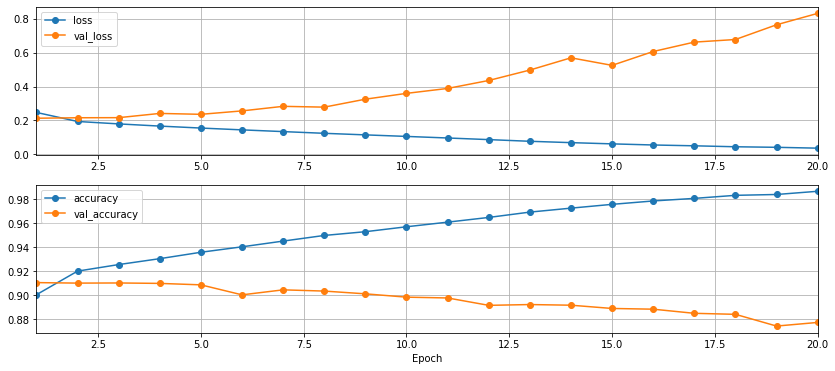

574/574 [==============================] - 4s 6ms/step - loss: 0.8229 - accuracy: 0.8739
[0.8228945136070251, 0.8738694787025452]


In [12]:
## display performances
plot_history(history, width=14)

## evaluate test set in the model
print(model.evaluate(X_test_sequences, y_test))

## Compute prediction using test generator
prediction = model.predict(X_test_sequences)

In [13]:
## Decoding labels
y_true = y_test.values
prediction_decoded = round(prediction.flatten())

In [14]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[ 1635   996]
 [ 1319 14404]]
              precision    recall  f1-score   support

           0       0.55      0.62      0.59      2631
           1       0.94      0.92      0.93     15723

    accuracy                           0.87     18354
   macro avg       0.74      0.77      0.76     18354
weighted avg       0.88      0.87      0.88     18354



## Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 2 (Accuracy metric).

In [18]:
## Model building
inputs = layers.Input(shape=(TEXT_MAX_LENG,), 
                      name='Input')
embedding_layer = TokenAndPositionEmbedding(TEXT_MAX_LENG, 
                                            MAX_WORDS, 
                                            EMBEDDING_DIM)
x = embedding_layer(inputs)
transformer = TransformerLayer(NUM_ATTENTION_HEADS, 
                               EMBEDDING_DIM, 
                               ff_dim=32)
x = transformer(x)
x = layers.GlobalAveragePooling1D(name='GlobalAvgPool')(x)
x = layers.Dropout(rate=0.1, name='Dropout_01')(x)
x = layers.Dense(20, activation="relu", name='Dense')(x)
x = layers.Dropout(rate=0.1, name='Dropout_02')(x)
outputs = layers.Dense(1, activation="sigmoid", name='Output')(x)

## Model instance
model = Model(inputs=inputs, outputs=outputs, name='Transformer')

## Compiler settings
model.compile(optimizer=Adam(), 
              loss="binary_crossentropy", 
              metrics=["accuracy"]
              )

start = time()

## Model fitting
history = model.fit(X_train_sequences, y_train,
                    batch_size=32, epochs=2)

print('Time spent: {:.2f}'.format(time() -start))

Epoch 1/2
5162/5162 [==============================] - 71s 13ms/step - loss: 0.2460 - accuracy: 0.9011
Epoch 2/2
5162/5162 [==============================] - 69s 13ms/step - loss: 0.1983 - accuracy: 0.9180
Time spent: 140.31


In [19]:
## evaluate test set in the model
print(model.evaluate(X_test_sequences, y_test))

## Compute prediction using test generator
prediction = model.predict(X_test_sequences)

574/574 [==============================] - 4s 6ms/step - loss: 0.2014 - accuracy: 0.9157
[0.2014063000679016, 0.915658712387085]


In [20]:
## Decoding labels
y_true = y_test.values
prediction_decoded = round(prediction.flatten())

## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[ 1656   975]
 [  573 15150]]
              precision    recall  f1-score   support

           0       0.74      0.63      0.68      2631
           1       0.94      0.96      0.95     15723

    accuracy                           0.92     18354
   macro avg       0.84      0.80      0.82     18354
weighted avg       0.91      0.92      0.91     18354

